In [1]:
# Cell 1: Imports and environment setup
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from tqdm import tqdm
import time

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cpu


In [2]:
# Cell 2: Configuration and paths
DATA_PATH = "data"  # Adjust if necessary
ADJ_FILE = os.path.join(DATA_PATH, "adj_METR-LA.pkl")
H5_FILE = os.path.join(DATA_PATH, "METR-LA.h5")
SENSOR_LOC_FILE = os.path.join(DATA_PATH, "graph_sensor_locations.csv")  

# Graph construction parameters
CORR_THRESHOLD = 0.6

# Model parameters
INPUT_DIM = 1
HIDDEN_DIM = 24
OUTPUT_DIM = 1
EPOCHS = 5
LR = 0.01
DROPOUT = 1e-5
WEIGHT_DECAY = 1e-9
SEEDS = [0, 1, 2]  # For reproducibility runs

# Temporal settings
HIST_LEN = 12  # number of input time steps
PRED_LEN = 3   # prediction steps
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.1
TEST_SPLIT = 0.2


In [3]:
# Cell 3: Inspect the h5 file
with h5py.File(H5_FILE, 'r') as f:
    row_labels = [str(label) for label in f['df']['axis1'][:]]
    column_labels = [label.decode('utf-8') for label in f['df']['block0_items'][:]]
    data = f['df']['block0_values'][:]
    df = pd.DataFrame(data, index=row_labels, columns=column_labels)

df.index = pd.to_numeric(df.index)  # Ensure the index is numeric
df.index = pd.to_datetime(df.index // 1_000_000_000, unit='s')  # Convert nanoseconds to seconds

print("DataFrame shape:", df.shape)
print("DataFrame head:")
display(df.head())
display(df.tail())


DataFrame shape: (34272, 207)
DataFrame head:


,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
2012-03-01 00:00:00,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125,67.125,59.625000,62.750000,...,45.625000,65.500,64.500000,66.428571,66.875,59.375000,69.000000,59.250000,69.000000,61.875
2012-03-01 00:05:00,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000,65.000,57.444444,63.333333,...,50.666667,69.875,66.666667,58.555556,62.000,61.111111,64.444444,55.888889,68.444444,62.875
2012-03-01 00:10:00,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500,64.250,63.875000,65.375000,...,44.125000,69.000,56.500000,59.250000,68.125,62.500000,65.625000,61.375000,69.857143,62.000
2012-03-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
2012-03-01 00:20:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000


,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
2012-06-27 23:35:00,65.000000,65.888889,68.555556,61.666667,0.0,54.555556,62.444444,63.333333,59.222222,65.333333,...,52.888889,69.000000,65.111111,55.666667,66.333333,62.444444,66.777778,64.888889,69.666667,62.333333
2012-06-27 23:40:00,61.375000,65.625000,66.500000,62.750000,0.0,50.500000,62.000000,67.000000,65.250000,67.125000,...,54.000000,69.250000,60.125000,60.500000,67.250000,59.375000,66.000000,61.250000,69.000000,62.000000
2012-06-27 23:45:00,67.000000,59.666667,69.555556,61.000000,0.0,44.777778,64.222222,63.777778,59.777778,57.666667,...,51.333333,67.888889,64.333333,57.000000,66.000000,62.666667,68.666667,63.333333,67.444444,61.222222
2012-06-27 23:50:00,66.750000,62.250000,66.000000,59.625000,0.0,53.000000,64.285714,64.125000,60.875000,66.250000,...,51.125000,69.375000,61.625000,60.500000,65.625000,66.375000,69.500000,63.000000,67.875000,63.500000
2012-06-27 23:55:00,65.111111,66.888889,66.777778,61.222222,0.0,49.555556,65.777778,65.111111,63.000000,61.666667,...,56.000000,67.444444,64.888889,60.888889,64.222222,66.444444,68.444444,63.555556,68.666667,61.777778


/var/folders/ys/ms1hq2dd27g6h1f_42k3brqc0000gn/T/ipykernel_34332/2190919429.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


Number of NaN values: 0
Raw data array shape: (207, 34272)
Number of sensors (N): 207
Number of time steps (T): 34272


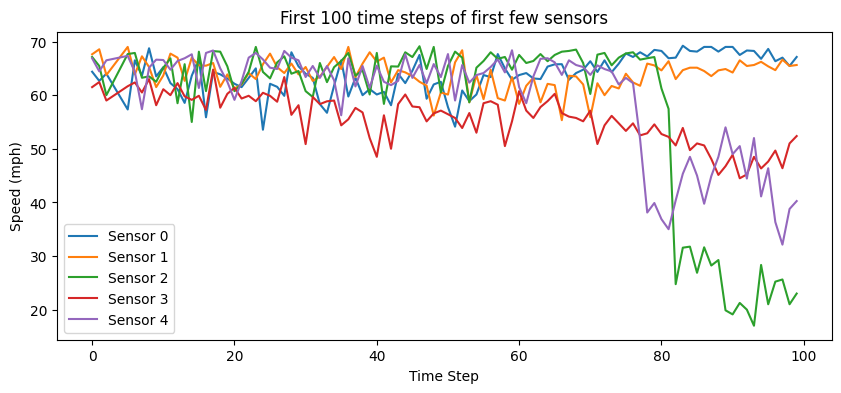

In [4]:
# Cell 4: Prepare the data
# Replace zeros with NaN
df = df.replace(0, np.nan)

# Interpolate missing values
df = df.interpolate(method='time')
df = df.fillna(method='ffill').fillna(method='bfill')

# Check no NaNs
print(f"Number of NaN values: {df.isna().sum().sum()}")

raw_data = df.values.T  # shape (N, T)
N, T = raw_data.shape
print("Raw data array shape:", raw_data.shape)
print("Number of sensors (N):", N)
print("Number of time steps (T):", T)

# Visualize a few sensors
plt.figure(figsize=(10,4))
for i in range(min(N,5)):
    plt.plot(raw_data[i,:100], label=f'Sensor {i}')
plt.title("First 100 time steps of first few sensors")
plt.xlabel("Time Step")
plt.ylabel("Speed (mph)")
plt.legend()
plt.show()


In [5]:
# Cell 5: Data splitting and normalization

def generate_train_val_test(data, train_ratio=0.7, val_ratio=0.1):
    num_samples = data.shape[1]
    train_end = int(num_samples * train_ratio)
    val_end = int(num_samples * (train_ratio + val_ratio))

    train_data = data[:, :train_end]
    val_data = data[:, train_end:val_end]
    test_data = data[:, val_end:]
    return train_data, val_data, test_data

def zscore_normalize(train_data, val_data, test_data):
    scaler = StandardScaler()
    train_flat = train_data.flatten().reshape(-1,1)
    scaler.fit(train_flat)
    
    def transform(x):
        return scaler.transform(x.flatten().reshape(-1,1)).reshape(x.shape)
    
    train_norm = transform(train_data)
    val_norm = transform(val_data)
    test_norm = transform(test_data)
    return train_norm, val_norm, test_norm, scaler

train_data, val_data, test_data = generate_train_val_test(raw_data, TRAIN_SPLIT, VAL_SPLIT)
train_norm, val_norm, test_norm, scaler = zscore_normalize(train_data, val_data, test_data)

print("Train shape:", train_data.shape, "Val shape:", val_data.shape, "Test shape:", test_data.shape)
print("Normalized Train min/max:", train_norm.min(), train_norm.max())
print("Scaler mean:", scaler.mean_[0], "Scaler scale:", scaler.scale_[0])


Train shape: (207, 23990) Val shape: (207, 3427) Test shape: (207, 6855)
Normalized Train min/max: -4.521248159977167 0.8983500965367791
Scaler mean: 58.45208560428384 Scaler scale: 12.854581348891058


In [6]:
# Cell 6: Create sliding windows
def create_sliding_window(data, hist_len, pred_len):
    N, T = data.shape
    samples = T - hist_len - pred_len + 1
    if samples <= 0:
        raise ValueError("Not enough data to create sliding windows with given hist_len and pred_len.")
    X = []
    y = []
    for i in range(samples):
        X.append(data[:, i:i+hist_len])
        y.append(data[:, i+hist_len:i+hist_len+pred_len])
    X = np.stack(X, axis=0)  # (samples, N, hist_len)
    y = np.stack(y, axis=0)  # (samples, N, pred_len)
    return X, y

X_train, y_train = create_sliding_window(train_norm, HIST_LEN, PRED_LEN)
X_val, y_val = create_sliding_window(val_norm, HIST_LEN, PRED_LEN)
X_test, y_test = create_sliding_window(test_norm, HIST_LEN, PRED_LEN)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)


X_train shape: (23976, 207, 12) y_train shape: (23976, 207, 3)


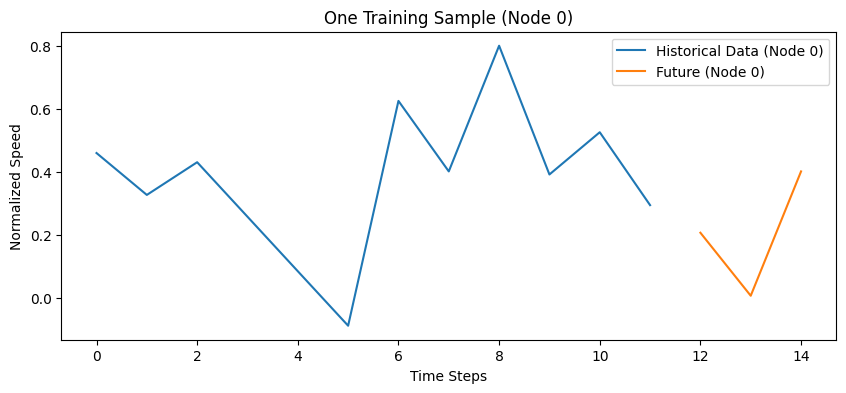

In [7]:
# Cell 7: Check a sample
sample_idx = 0
plt.figure(figsize=(10,4))
plt.plot(range(HIST_LEN), X_train[sample_idx, 0, :], label='Historical Data (Node 0)')
plt.plot(range(HIST_LEN, HIST_LEN+PRED_LEN), y_train[sample_idx, 0, :], label='Future (Node 0)')
plt.title("One Training Sample (Node 0)")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Speed")
plt.legend()
plt.show()


In [8]:
# Cell 8: Create DataLoaders
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_t, y_train_t), batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_t, y_val_t), batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_t, y_test_t), batch_size=16, shuffle=False)


In [9]:
# Cell 9: Load adjacency and construct graphs
def load_distance_adj(adj_file):
    with open(adj_file, 'rb') as f:
        sensor_ids, sensor_id_to_ind, adj_mx = pickle.load(f, encoding='latin1')
    return sensor_ids, sensor_id_to_ind, adj_mx

sensor_ids, sensor_id_to_ind, adj_mx = load_distance_adj(ADJ_FILE)
print("Adjacency matrix shape:", adj_mx.shape)

# Construct correlation-based adjacency matrix
corr = np.corrcoef(train_norm)
corr_adj = (corr >= CORR_THRESHOLD).astype(np.float32)

# Distance-based adjacency (binary)
dist_adj = (adj_mx > 0).astype(np.float32)

print("Correlation-based adj edges:", corr_adj.sum())
print("Distance-based adj edges:", dist_adj.sum())


Adjacency matrix shape: (207, 207)
Correlation-based adj edges: 2099.0
Distance-based adj edges: 1722.0


In [10]:
# Cell 10: Helper functions
def compute_random_walk_matrix(adj):
    d = np.sum(adj, axis=1)
    d_inv = 1.0 / d
    d_inv[np.isinf(d_inv)] = 0.
    D_inv = np.diag(d_inv)
    return (D_inv @ adj).astype(np.float32)

def normalize_adjacency(A):
    A = A.astype(np.float32)
    row_sum = A.sum(axis=1)
    row_sum[row_sum == 0] = 1
    A_norm = A / row_sum[:, None]
    return A_norm


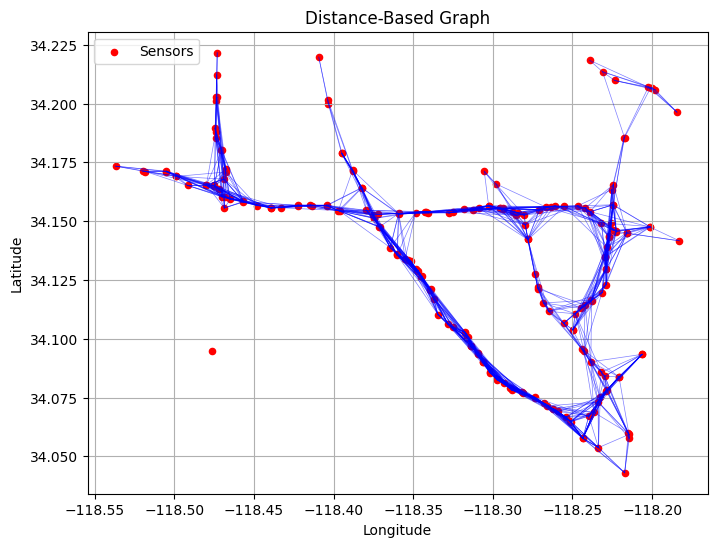

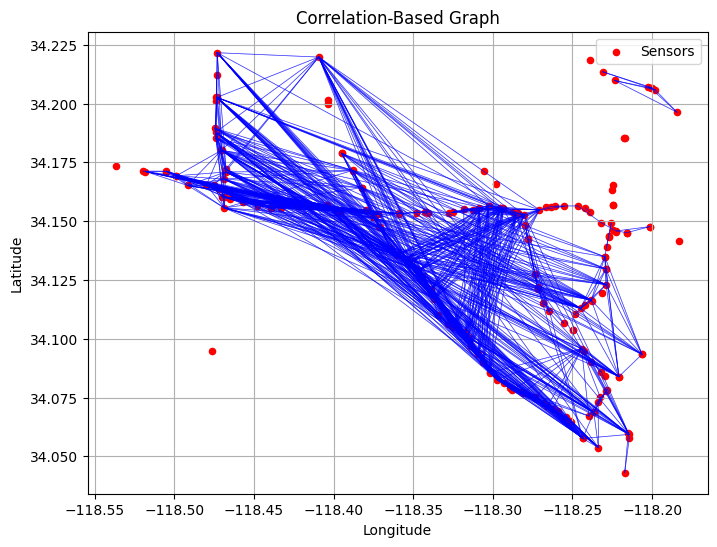

In [11]:
# Cell 11: Plot the Sensor Graph

sensor_loc_df = pd.read_csv(SENSOR_LOC_FILE)

# Ensure matching types. Let's assume sensor_ids are integers:
sensor_ids_int = [int(sid) for sid in sensor_ids]
sensor_loc_df['sensor_id'] = sensor_loc_df['sensor_id'].astype(int)

sensor_loc_df = sensor_loc_df.merge(pd.DataFrame({'sensor_id': sensor_ids_int}), on='sensor_id', how='right')

latitudes = sensor_loc_df['latitude'].values
longitudes = sensor_loc_df['longitude'].values

def plot_graph(lat, lon, adj_matrix, title="Graph"):
    plt.figure(figsize=(8,6))
    plt.scatter(lon, lat, c='r', s=20, label='Sensors')
    N = adj_matrix.shape[0]
    for i in range(N):
        for j in range(N):
            if adj_matrix[i,j] > 0:
                plt.plot([lon[i], lon[j]], [lat[i], lat[j]], c='b', linewidth=0.5, alpha=0.5)
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_graph(latitudes, longitudes, dist_adj, title="Distance-Based Graph")
plot_graph(latitudes, longitudes, corr_adj, title="Correlation-Based Graph")

In [12]:
# Cell 12: DCRNN Model

class DiffusionGraphConv(nn.Module):
    """
    Diffusion convolution layer as described in DCRNN.
    """
    def __init__(self, in_channels, out_channels, k=2, bias=True):
        super(DiffusionGraphConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.k = k
        self.weight = nn.Parameter(torch.FloatTensor(2 * k * in_channels, out_channels))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, x, adj_fwd, adj_bwd):
        # x: (B, N, C)
        B, N, C = x.shape
        out = []
        x_fwd = x
        x_bwd = x
        for step in range(self.k):
            x_fwd = torch.einsum('ij,bjc->bic', adj_fwd, x_fwd)
            x_bwd = torch.einsum('ij,bjc->bic', adj_bwd, x_bwd)
            out.append(x_fwd)
            out.append(x_bwd)
        out = torch.cat(out, dim=-1)  # (B, N, 2*k*C)
        out = torch.einsum('bni,io->bno', out, self.weight)
        if self.bias is not None:
            out = out + self.bias
        return out

class DCRNNCell(nn.Module):
    def __init__(self, num_nodes, in_channels, hidden_dim, k=2):
        super(DCRNNCell, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        self.gc_xg = DiffusionGraphConv(in_channels + hidden_dim, hidden_dim, k=k)
        self.gc_xr = DiffusionGraphConv(in_channels + hidden_dim, hidden_dim, k=k)
        self.gc_xh = DiffusionGraphConv(in_channels + hidden_dim, hidden_dim, k=k)

    def forward(self, x, h, adj_fwd, adj_bwd):
        x_h = torch.cat([x, h], dim=-1)  # (B, N, C_in+hidden_dim)
        z = torch.sigmoid(self.gc_xg(x_h, adj_fwd, adj_bwd))
        r = torch.sigmoid(self.gc_xr(x_h, adj_fwd, adj_bwd))
        x_h_new = torch.cat([x, r * h], dim=-1)
        h_tilde = torch.tanh(self.gc_xh(x_h_new, adj_fwd, adj_bwd))
        h_new = (1 - z) * h + z * h_tilde
        return h_new

class DCRNNEncoder(nn.Module):
    def __init__(self, num_nodes, input_dim, hidden_dim, k=2):
        super(DCRNNEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        self.cell = DCRNNCell(num_nodes, input_dim, hidden_dim, k=k)

    def forward(self, X, adj_fwd, adj_bwd):
        # X: (B, N, T)
        B, N, T = X.shape
        h = torch.zeros(B, N, self.hidden_dim, device=X.device)
        for t in range(T):
            x_t = X[:, :, t:t+1]  # (B, N, 1)
            h = self.cell(x_t, h, adj_fwd, adj_bwd)
        return h

class DCRNNDecoder(nn.Module):
    def __init__(self, num_nodes, hidden_dim, pred_len, k=2):
        super(DCRNNDecoder, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        self.pred_len = pred_len
        self.cell = DCRNNCell(num_nodes, 1, hidden_dim, k=k)  # input_dim=1 for decoder steps
        self.fc = nn.Linear(hidden_dim, 1)  # Predict one step ahead

    def forward(self, h, adj_fwd, adj_bwd, init_input):
        # h: initial hidden state from encoder (B, N, hidden_dim)
        # init_input: (B, N, 1), e.g., last observed input
        # We decode step-by-step for pred_len steps.
        y_t = init_input
        outputs = []
        for t in range(self.pred_len):
            h = self.cell(y_t, h, adj_fwd, adj_bwd)
            out_t = self.fc(h)  # (B, N, 1)
            outputs.append(out_t)
            y_t = out_t  # feeding the previous output as input for next step
        outputs = torch.cat(outputs, dim=-1)  # (B, N, pred_len)
        return outputs

class DCRNN(nn.Module):
    def __init__(self, num_nodes, input_dim, hidden_dim, pred_len, k=2):
        super(DCRNN, self).__init__()
        self.encoder = DCRNNEncoder(num_nodes, input_dim, hidden_dim, k=k)
        self.decoder = DCRNNDecoder(num_nodes, hidden_dim, pred_len, k=k)

    def forward(self, X, adj_fwd, adj_bwd):
        # X: (B, N, T_in)
        # 1. Encode the input sequence
        h = self.encoder(X, adj_fwd, adj_bwd)

        # 2. Decode: Use the last input step as the init for the decoder
        init_input = X[:, :, -1:]  # (B, N, 1)
        outputs = self.decoder(h, adj_fwd, adj_bwd, init_input)

        return outputs


In [13]:
# Cell 13: Baseline LSTM Model
class BaselineLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, pred_len, dropout=0.3, num_layers=1):
        super(BaselineLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, pred_len)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, N, T)
        B, N, T = x.shape
        x = x.unsqueeze(-1)  # (B, N, T, 1)
        x = x.view(B*N, T, 1)

        out, (h_n, c_n) = self.lstm(x)
        h_n = h_n[-1]
        h_n = self.dropout_layer(h_n)
        y = self.fc(h_n)
        y = y.view(B, N, -1)
        return y


In [15]:
# Cell 14: Evaluation and training utilities

def evaluate(model, loader, A, device, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            if A is not None:
                out = model(Xb, A)  # pass A
            else:
                out = model(Xb)
            loss = criterion(out, yb)
            losses.append(loss.item())
    return np.mean(losses)

def test_evaluate(model, loader, A, device, scaler):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            if A is not None:
                out = model(Xb, A)
            else:
                out = model(Xb)
            preds.append(out.cpu().numpy())
            trues.append(yb.numpy())
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    
    preds = preds.flatten().reshape(-1,1)
    trues = trues.flatten().reshape(-1,1)
    preds = scaler.inverse_transform(preds).flatten()
    trues = scaler.inverse_transform(trues).flatten()
    
    mae = np.mean(np.abs(preds - trues))
    rmse = np.sqrt(np.mean((preds - trues)**2))
    print(f"Test: MAE={mae:.4f}, RMSE={rmse:.4f}")
    return mae, rmse

def train_model(model, optimizer, criterion, train_loader, val_loader, A, device, epochs=5, early_stop_patience=10):
    best_val_loss = float('inf')
    patience_count = 0
    best_model_state = None

    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        model.train()
        train_losses = []
        num_batches = len(train_loader)

        with tqdm(total=num_batches, desc=f"Epoch {epoch + 1}/{epochs}", leave=False) as pbar:
            for batch_idx, (Xb, yb) in enumerate(train_loader):
                Xb, yb = Xb.to(device), yb.to(device)
                optimizer.zero_grad()
                if A is not None:
                    out = model(Xb, A)
                else:
                    out = model(Xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

                if (batch_idx + 1) % 50 == 0:
                    avg_train_loss = np.mean(train_losses[-50:])
                    pbar.set_postfix(AvgTrainLoss=f"{avg_train_loss:.4f}")
                pbar.update(1)

        avg_train_loss = np.mean(train_losses)
        val_loss = evaluate(model, val_loader, A, device, criterion)
        train_loss_history.append(avg_train_loss)
        val_loss_history.append(val_loss)

        print(
            f"Epoch {epoch + 1}/{epochs}, "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Val Loss: {val_loss:.4f}, "
            f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}"
        )
        
        # Decay LR by factor 0.5 for demonstration
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.5

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_count = 0
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_count += 1
            if patience_count > early_stop_patience:
                print("Early stopping triggered.")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model, train_loss_history, val_loss_history


In [16]:
# Cell 15: Experiment running and plotting utilities

def run_experiment(A, seeds, graph_name, train_loader, val_loader, test_loader, scaler, 
                   model_class, input_dim=1, hidden_dim=128, pred_len=3, dropout=0.3, epochs=5, lr=0.0005):
    maes = []
    rmses = []
    all_train_loss_histories = []
    all_val_loss_histories = []

    overall_start = time.time()
    print(f"Starting experiment for {graph_name} with seeds: {seeds}")
    for s in seeds:
        print(f"Running seed {s}...")
        torch.manual_seed(s)
        np.random.seed(s)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(s)
        
        model = model_class(input_dim, hidden_dim, pred_len, dropout=dropout).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
        criterion = nn.MSELoss()

        trained_model, train_loss_history, val_loss_history = train_model(
            model, optimizer, criterion, train_loader, val_loader, A, DEVICE, epochs=epochs
        )
        mae, rmse = test_evaluate(trained_model, test_loader, A, DEVICE, scaler)
        maes.append(mae)
        rmses.append(rmse)
        all_train_loss_histories.append(train_loss_history)
        all_val_loss_histories.append(val_loss_history)
    
    total_time = time.time() - overall_start
    print(f"Results for {graph_name} after all seeds:")
    print(f"MAE: {np.mean(maes):.4f} ± {np.std(maes):.4f}")
    print(f"RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
    print(f"Total experiment time: {total_time:.2f}s")

    avg_train_loss = np.mean([np.array(h) for h in all_train_loss_histories], axis=0)
    avg_val_loss = np.mean([np.array(h) for h in all_val_loss_histories], axis=0)

    return np.mean(maes), np.std(maes), np.mean(rmses), np.std(rmses), avg_train_loss, avg_val_loss

def plot_loss_curves(train_loss, val_loss, title="Training & Validation Loss"):
    plt.figure(figsize=(8,5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [17]:
# Cell 16: DCRNN training and evaluation

def evaluate_dcrnn(model, loader, adj_fwd, adj_bwd, device, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb, adj_fwd, adj_bwd)
            loss = criterion(out, yb)
            losses.append(loss.item())
    return np.mean(losses)

def test_evaluate_dcrnn(model, loader, adj_fwd, adj_bwd, device, scaler):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            out = model(Xb, adj_fwd, adj_bwd)
            preds.append(out.cpu().numpy())
            trues.append(yb.numpy())
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)

    preds = preds.flatten().reshape(-1,1)
    trues = trues.flatten().reshape(-1,1)
    preds = scaler.inverse_transform(preds).flatten()
    trues = scaler.inverse_transform(trues).flatten()

    mae = np.mean(np.abs(preds - trues))
    rmse = np.sqrt(np.mean((preds - trues)**2))
    print(f"Test: MAE={mae:.4f}, RMSE={rmse:.4f}")
    return mae, rmse

def run_dcrnn_experiment(adj_matrix, graph_name, seeds, train_loader, val_loader, test_loader, scaler, 
                         input_dim=1, hidden_dim=64, pred_len=3, epochs=5, lr=0.001, weight_decay=7e-4, k=2):
    adj_fwd = compute_random_walk_matrix(adj_matrix)
    adj_bwd = compute_random_walk_matrix(adj_matrix.T)

    adj_fwd_t = torch.tensor(adj_fwd, dtype=torch.float32, device=DEVICE)
    adj_bwd_t = torch.tensor(adj_bwd, dtype=torch.float32, device=DEVICE)

    maes = []
    rmses = []
    all_train_loss_histories = []
    all_val_loss_histories = []
    overall_start = time.time()
    print(f"Starting DCRNN experiment for {graph_name} with seeds: {seeds}")
    for s in seeds:
        print(f"Running seed {s}...")
        torch.manual_seed(s)
        np.random.seed(s)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(s)

        num_nodes = adj_matrix.shape[0]
        model = DCRNN(num_nodes, input_dim, hidden_dim, pred_len, k=k).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        best_val_loss = float('inf')
        patience_count = 0
        best_model_state = None
        train_loss_history = []
        val_loss_history = []

        for epoch in range(epochs):
            model.train()
            train_losses = []
            num_batches = len(train_loader)

            with tqdm(total=num_batches, desc=f"Epoch {epoch + 1}/{epochs}", leave=False) as pbar:
                for batch_idx, (Xb, yb) in enumerate(train_loader):
                    Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
                    optimizer.zero_grad()
                    out = model(Xb, adj_fwd_t, adj_bwd_t)
                    loss = criterion(out, yb)
                    loss.backward()
                    optimizer.step()
                    train_losses.append(loss.item())

                    if (batch_idx + 1) % 50 == 0:
                        avg_train_loss = np.mean(train_losses[-50:])
                        pbar.set_postfix(AvgLoss=f"{avg_train_loss:.4f}")
                    pbar.update(1)

            avg_train_loss = np.mean(train_losses)
            val_loss = evaluate_dcrnn(model, val_loader, adj_fwd_t, adj_bwd_t, DEVICE, criterion)
            train_loss_history.append(avg_train_loss)
            val_loss_history.append(val_loss)

            print(
                f"Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {avg_train_loss:.4f}, "
                f"Val Loss: {val_loss:.4f}, "
                f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}"
            )
            
            # Example: reduce LR by factor of 0.9 each epoch
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.5

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_count = 0
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            else:
                patience_count += 1
                if patience_count > 10:
                    print("Early stopping triggered.")
                    break
        
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        mae, rmse = test_evaluate_dcrnn(model, test_loader, adj_fwd_t, adj_bwd_t, DEVICE, scaler)
        maes.append(mae)
        rmses.append(rmse)
        all_train_loss_histories.append(train_loss_history)
        all_val_loss_histories.append(val_loss_history)
    
    total_time = time.time() - overall_start
    print(f"Results for {graph_name} after all seeds:")
    print(f"MAE: {np.mean(maes):.4f} ± {np.std(maes):.4f}")
    print(f"RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
    print(f"Total experiment time: {total_time:.2f}s")

    avg_train_loss = np.mean([np.array(h) for h in all_train_loss_histories], axis=0)
    avg_val_loss = np.mean([np.array(h) for h in all_val_loss_histories], axis=0)
    return np.mean(maes), np.std(maes), np.mean(rmses), np.std(rmses), avg_train_loss, avg_val_loss


In [18]:
# Cell 17: Prepare for experiments

# Normalize adjacency for GCN-based models
A_dist = normalize_adjacency(dist_adj)
A_corr = normalize_adjacency(corr_adj)

A_dist_t = torch.tensor(A_dist, dtype=torch.float32, device=DEVICE)
A_corr_t = torch.tensor(A_corr, dtype=torch.float32, device=DEVICE)


/Users/primary/Documents/GitHub/deep-learning/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1e-05 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting experiment for LSTM-Only with seeds: [0, 1, 2]
Running seed 0...


Epoch 1/5:   0%|          | 0/1499 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 0.1483, Val Loss: 0.1332, Learning Rate: 0.010000


Epoch 2/5, Train Loss: 0.1405, Val Loss: 0.1321, Learning Rate: 0.005000


Epoch 3/5, Train Loss: 0.1393, Val Loss: 0.1319, Learning Rate: 0.002500


Epoch 4/5, Train Loss: 0.1387, Val Loss: 0.1314, Learning Rate: 0.001250


Epoch 5/5, Train Loss: 0.1383, Val Loss: 0.1315, Learning Rate: 0.000625


/Users/primary/Documents/GitHub/deep-learning/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1e-05 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Test: MAE=2.6049, RMSE=4.8436
Running seed 1...


Epoch 1/5, Train Loss: 0.1480, Val Loss: 0.1346, Learning Rate: 0.010000


Epoch 2/5, Train Loss: 0.1406, Val Loss: 0.1336, Learning Rate: 0.005000


Epoch 3/5, Train Loss: 0.1394, Val Loss: 0.1318, Learning Rate: 0.002500


Epoch 4/5, Train Loss: 0.1386, Val Loss: 0.1312, Learning Rate: 0.001250


Epoch 5/5, Train Loss: 0.1383, Val Loss: 0.1311, Learning Rate: 0.000625


/Users/primary/Documents/GitHub/deep-learning/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1e-05 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Test: MAE=2.5888, RMSE=4.8389
Running seed 2...


Epoch 1/5, Train Loss: 0.1488, Val Loss: 0.1335, Learning Rate: 0.010000


Epoch 2/5, Train Loss: 0.1403, Val Loss: 0.1321, Learning Rate: 0.005000


Epoch 3/5, Train Loss: 0.1391, Val Loss: 0.1316, Learning Rate: 0.002500


Epoch 4/5, Train Loss: 0.1385, Val Loss: 0.1312, Learning Rate: 0.001250


Epoch 5/5, Train Loss: 0.1383, Val Loss: 0.1311, Learning Rate: 0.000625
Test: MAE=2.5892, RMSE=4.8402
Results for LSTM-Only after all seeds:
MAE: 2.5943 ± 0.0075
RMSE: 4.8409 ± 0.0020
Total experiment time: 1215.40s


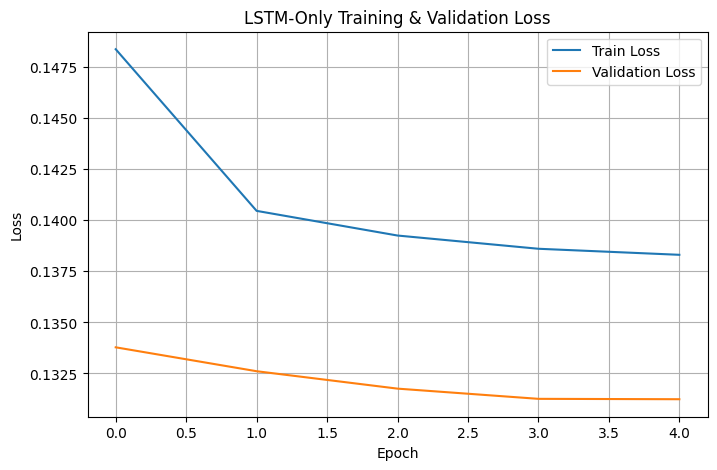

LSTM-Only: MAE=2.5943 ± 0.0075, RMSE=4.8409 ± 0.0020


In [23]:
# Cell 18: LSTM
lstm_mae_mean, lstm_mae_std, lstm_rmse_mean, lstm_rmse_std, lstm_train_loss, lstm_val_loss = run_experiment(
    None, SEEDS, "LSTM-Only", train_loader, val_loader, test_loader, scaler,
    model_class=BaselineLSTMModel, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, 
    pred_len=PRED_LEN, dropout=DROPOUT, epochs=EPOCHS, lr=LR
)

plot_loss_curves(lstm_train_loss, lstm_val_loss, title="LSTM-Only Training & Validation Loss")
print(f"LSTM-Only: MAE={lstm_mae_mean:.4f} ± {lstm_mae_std:.4f}, RMSE={lstm_rmse_mean:.4f} ± {lstm_rmse_std:.4f}")


Starting DCRNN experiment for DCRNN (Distance-Based) with seeds: [0, 1, 2]
Running seed 0...


Epoch 1/5, Train Loss: 0.1948, Val Loss: 0.1483, Learning Rate: 0.010000


Epoch 2/5, Train Loss: 0.1457, Val Loss: 0.1323, Learning Rate: 0.005000


Epoch 3/5, Train Loss: 0.1394, Val Loss: 0.1300, Learning Rate: 0.002500


Epoch 4/5, Train Loss: 0.1364, Val Loss: 0.1275, Learning Rate: 0.001250


Epoch 5/5, Train Loss: 0.1348, Val Loss: 0.1267, Learning Rate: 0.000625
Test: MAE=2.8960, RMSE=4.8187
Running seed 1...


Epoch 1/5, Train Loss: 0.2029, Val Loss: 0.1474, Learning Rate: 0.010000


Epoch 2/5, Train Loss: 0.1480, Val Loss: 0.1351, Learning Rate: 0.005000


Epoch 3/5, Train Loss: 0.1405, Val Loss: 0.1306, Learning Rate: 0.002500


Epoch 4/5, Train Loss: 0.1372, Val Loss: 0.1294, Learning Rate: 0.001250


Epoch 5/5, Train Loss: 0.1355, Val Loss: 0.1274, Learning Rate: 0.000625
Test: MAE=2.9075, RMSE=4.8290
Running seed 2...


Epoch 1/5, Train Loss: 0.1998, Val Loss: 0.1448, Learning Rate: 0.010000


Epoch 2/5, Train Loss: 0.1471, Val Loss: 0.1341, Learning Rate: 0.005000


Epoch 3/5, Train Loss: 0.1405, Val Loss: 0.1312, Learning Rate: 0.002500


Epoch 4/5, Train Loss: 0.1374, Val Loss: 0.1299, Learning Rate: 0.001250


Epoch 5/5, Train Loss: 0.1358, Val Loss: 0.1278, Learning Rate: 0.000625
Test: MAE=2.9071, RMSE=4.8355
Results for DCRNN (Distance-Based) after all seeds:
MAE: 2.9035 ± 0.0053
RMSE: 4.8277 ± 0.0069
Total experiment time: 3813.43s


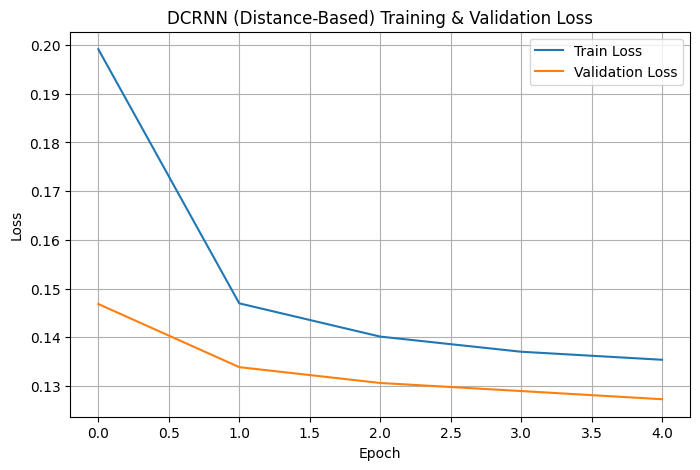

DCRNN (Distance): MAE=2.9035 ± 0.0053, RMSE=4.8277 ± 0.0069


In [21]:
# Cell 19: DCRNN (Distance-based)
dcrnn_dist_mae_mean, dcrnn_dist_mae_std, dcrnn_dist_rmse_mean, dcrnn_dist_rmse_std, dcrnn_dist_train_loss, dcrnn_dist_val_loss = run_dcrnn_experiment(
    dist_adj, "DCRNN (Distance-Based)", SEEDS, train_loader, val_loader, test_loader, scaler,
    input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, pred_len=PRED_LEN, epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY
)

plot_loss_curves(dcrnn_dist_train_loss, dcrnn_dist_val_loss, title="DCRNN (Distance-Based) Training & Validation Loss")

print(f"DCRNN (Distance): MAE={dcrnn_dist_mae_mean:.4f} ± {dcrnn_dist_mae_std:.4f}, RMSE={dcrnn_dist_rmse_mean:.4f} ± {dcrnn_dist_rmse_std:.4f}")


Starting DCRNN experiment for DCRNN (Correlation-Based) with seeds: [0, 1, 2]
Running seed 0...


Epoch 1/5, Train Loss: 0.2162, Val Loss: 0.1842, Learning Rate: 0.010000


Epoch 2/5, Train Loss: 0.1854, Val Loss: 0.1731, Learning Rate: 0.005000


Epoch 3/5, Train Loss: 0.1787, Val Loss: 0.1682, Learning Rate: 0.002500


Epoch 4/5, Train Loss: 0.1753, Val Loss: 0.1658, Learning Rate: 0.001250


Epoch 5/5, Train Loss: 0.1733, Val Loss: 0.1646, Learning Rate: 0.000625
Test: MAE=3.3928, RMSE=5.5021
Running seed 1...


Epoch 1/5, Train Loss: 0.2214, Val Loss: 0.1836, Learning Rate: 0.010000


Epoch 2/5, Train Loss: 0.1868, Val Loss: 0.1740, Learning Rate: 0.005000


Epoch 3/5, Train Loss: 0.1795, Val Loss: 0.1689, Learning Rate: 0.002500


Epoch 4/5, Train Loss: 0.1755, Val Loss: 0.1670, Learning Rate: 0.001250


Epoch 5/5, Train Loss: 0.1735, Val Loss: 0.1649, Learning Rate: 0.000625
Test: MAE=3.4095, RMSE=5.5074
Running seed 2...


Epoch 1/5, Train Loss: 0.2187, Val Loss: 0.1847, Learning Rate: 0.010000


Epoch 2/5, Train Loss: 0.1867, Val Loss: 0.1734, Learning Rate: 0.005000


Epoch 3/5, Train Loss: 0.1795, Val Loss: 0.1695, Learning Rate: 0.002500


Epoch 4/5, Train Loss: 0.1760, Val Loss: 0.1672, Learning Rate: 0.001250


Epoch 5/5, Train Loss: 0.1742, Val Loss: 0.1655, Learning Rate: 0.000625
Test: MAE=3.4044, RMSE=5.5194
Results for DCRNN (Correlation-Based) after all seeds:
MAE: 3.4022 ± 0.0070
RMSE: 5.5097 ± 0.0072
Total experiment time: 3808.74s


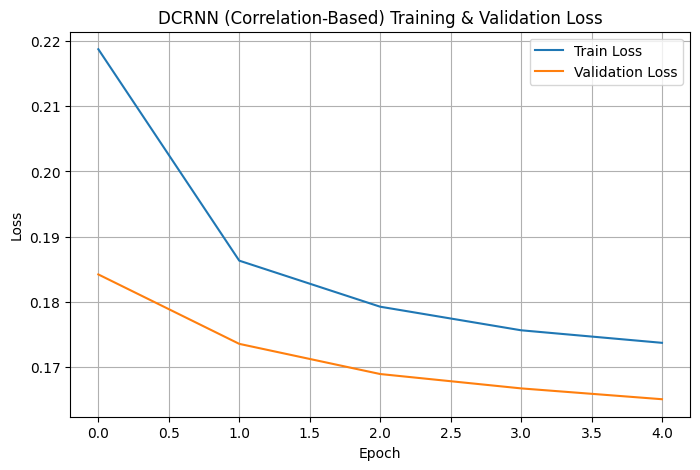

DCRNN (Correlation): MAE=3.4022 ± 0.0070, RMSE=5.5097 ± 0.0072


In [22]:
# Cell 20: DCRNN (Correlation-based)
dcrnn_corr_mae_mean, dcrnn_corr_mae_std, dcrnn_corr_rmse_mean, dcrnn_corr_rmse_std, dcrnn_corr_train_loss, dcrnn_corr_val_loss = run_dcrnn_experiment(
    corr_adj, "DCRNN (Correlation-Based)", SEEDS, train_loader, val_loader, test_loader, scaler,
    input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, pred_len=PRED_LEN, epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY
)

plot_loss_curves(dcrnn_corr_train_loss, dcrnn_corr_val_loss, title="DCRNN (Correlation-Based) Training & Validation Loss")
print(f"DCRNN (Correlation): MAE={dcrnn_corr_mae_mean:.4f} ± {dcrnn_corr_mae_std:.4f}, RMSE={dcrnn_corr_rmse_mean:.4f} ± {dcrnn_corr_rmse_std:.4f}")


In [26]:
# Cell 21: Define GCN-only model
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats, dropout=0.0):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(out_feats)

    def forward(self, x, A):
        # x: (B, N, F)
        # A: (N, N)
        # GCN: X' = A*X*W
        x = torch.einsum('ij,bjf->bif', A, x)   # A * X
        x = self.linear(x)                     # (B,N,F_out)
        x = self.dropout(x)
        B, N, feat_dim = x.shape
        x = x.reshape(B*N, feat_dim)
        x = self.bn(x)
        x = x.reshape(B, N, feat_dim)
        return F.relu(x)


class GCNOnlyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, pred_len, dropout=0.3):
        super(GCNOnlyModel, self).__init__()
        self.gcn1 = GCNLayer(input_dim, hidden_dim, dropout=dropout)
        self.gcn2 = GCNLayer(hidden_dim, hidden_dim, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, pred_len)

    def forward(self, X, A):
        # X: (B, N, T)
        # Average over time to remove temporal dimension, focusing only on spatial features
        x = X.mean(dim=2)  # (B, N)
        x = x.unsqueeze(-1) # (B, N, 1)
        
        # Apply GCN layers
        x = self.gcn1(x, A)
        x = self.gcn2(x, A)
        # x: (B,N,H)
        out = self.fc(x)  # (B,N,pred_len)
        return out

Starting experiment for GCN (Distance) with seeds: [0, 1, 2]
Running seed 0...


Epoch 1/5, Train Loss: 0.6695, Val Loss: 0.6042, Learning Rate: 0.010000


Epoch 2/5, Train Loss: 0.6650, Val Loss: 0.5960, Learning Rate: 0.005000


Epoch 3/5, Train Loss: 0.6626, Val Loss: 0.5928, Learning Rate: 0.002500


Epoch 4/5, Train Loss: 0.6610, Val Loss: 0.5930, Learning Rate: 0.001250


Epoch 5/5, Train Loss: 0.6607, Val Loss: 0.5927, Learning Rate: 0.000625
Test: MAE=7.4419, RMSE=10.7629
Running seed 1...


Epoch 1/5, Train Loss: 0.6702, Val Loss: 0.5941, Learning Rate: 0.010000


Epoch 2/5, Train Loss: 0.6629, Val Loss: 0.5926, Learning Rate: 0.005000


Epoch 3/5, Train Loss: 0.6630, Val Loss: 0.5925, Learning Rate: 0.002500


Epoch 4/5, Train Loss: 0.6620, Val Loss: 0.5930, Learning Rate: 0.001250


Epoch 5/5, Train Loss: 0.6612, Val Loss: 0.5964, Learning Rate: 0.000625
Test: MAE=7.3552, RMSE=10.7738
Running seed 2...


Epoch 1/5, Train Loss: 0.6700, Val Loss: 0.5993, Learning Rate: 0.010000


Epoch 2/5, Train Loss: 0.6642, Val Loss: 0.5924, Learning Rate: 0.005000


Epoch 3/5, Train Loss: 0.6617, Val Loss: 0.5911, Learning Rate: 0.002500


Epoch 4/5, Train Loss: 0.6610, Val Loss: 0.5909, Learning Rate: 0.001250


Epoch 5/5, Train Loss: 0.6604, Val Loss: 0.5906, Learning Rate: 0.000625
Test: MAE=7.3631, RMSE=10.7534
Results for GCN (Distance) after all seeds:
MAE: 7.3867 ± 0.0391
RMSE: 10.7634 ± 0.0084
Total experiment time: 109.45s


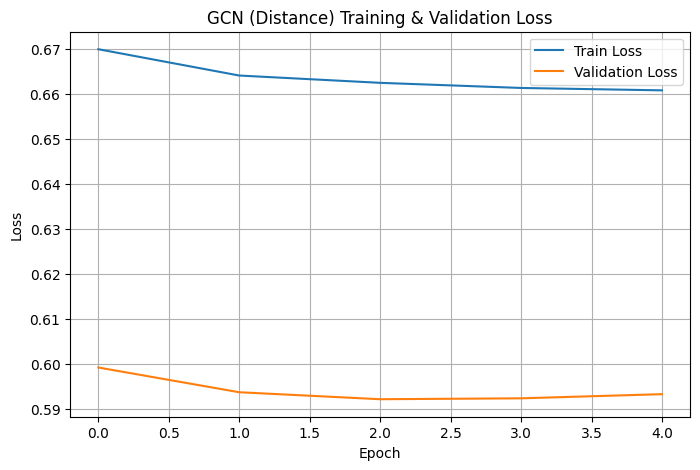

GCN (Distance): MAE=7.3867 ± 0.0391, RMSE=10.7634 ± 0.0084


In [28]:
# Cell 22: GCN with Distance
gcn_dist_mae_mean, gcn_dist_mae_std, gcn_dist_rmse_mean, gcn_dist_rmse_std, gcn_dist_train_loss, gcn_dist_val_loss = run_experiment(
    A_dist_t, SEEDS, "GCN (Distance)", train_loader, val_loader, test_loader, scaler,
    model_class=GCNOnlyModel, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, pred_len=PRED_LEN, 
    dropout=DROPOUT, epochs=EPOCHS, lr=LR
)

plot_loss_curves(gcn_dist_train_loss, gcn_dist_val_loss, title="GCN (Distance) Training & Validation Loss")
print(f"GCN (Distance): MAE={gcn_dist_mae_mean:.4f} ± {gcn_dist_mae_std:.4f}, RMSE={gcn_dist_rmse_mean:.4f} ± {gcn_dist_rmse_std:.4f}")

Starting experiment for GCN (Correlation) with seeds: [0, 1, 2]
Running seed 0...


Epoch 1/5, Train Loss: 0.4287, Val Loss: 0.3945, Learning Rate: 0.010000


Epoch 2/5, Train Loss: 0.4124, Val Loss: 0.3897, Learning Rate: 0.005000


Epoch 3/5, Train Loss: 0.4081, Val Loss: 0.3880, Learning Rate: 0.002500


Epoch 4/5, Train Loss: 0.4066, Val Loss: 0.3882, Learning Rate: 0.001250


Epoch 5/5, Train Loss: 0.4062, Val Loss: 0.3905, Learning Rate: 0.000625
Test: MAE=5.3797, RMSE=8.5138
Running seed 1...


Epoch 1/5, Train Loss: 0.4282, Val Loss: 0.4454, Learning Rate: 0.010000


Epoch 2/5, Train Loss: 0.4127, Val Loss: 0.3897, Learning Rate: 0.005000


Epoch 3/5, Train Loss: 0.4093, Val Loss: 0.3916, Learning Rate: 0.002500


Epoch 4/5, Train Loss: 0.4075, Val Loss: 0.3881, Learning Rate: 0.001250


Epoch 5/5, Train Loss: 0.4069, Val Loss: 0.3893, Learning Rate: 0.000625
Test: MAE=5.3493, RMSE=8.5030
Running seed 2...


Epoch 1/5, Train Loss: 0.4287, Val Loss: 0.3933, Learning Rate: 0.010000


Epoch 2/5, Train Loss: 0.4121, Val Loss: 0.3898, Learning Rate: 0.005000


Epoch 3/5, Train Loss: 0.4080, Val Loss: 0.3912, Learning Rate: 0.002500


Epoch 4/5, Train Loss: 0.4071, Val Loss: 0.3908, Learning Rate: 0.001250


Epoch 5/5, Train Loss: 0.4067, Val Loss: 0.3878, Learning Rate: 0.000625
Test: MAE=5.3407, RMSE=8.5062
Results for GCN (Correlation) after all seeds:
MAE: 5.3566 ± 0.0167
RMSE: 8.5077 ± 0.0045
Total experiment time: 106.31s


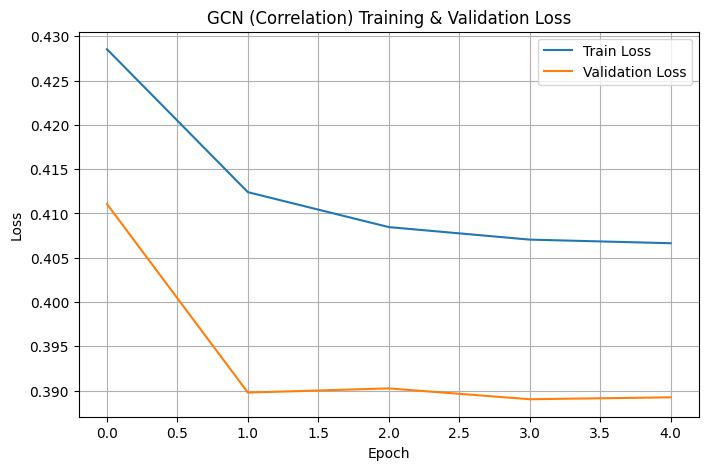

GCN (Correlation): MAE=5.3566 ± 0.0167, RMSE=8.5077 ± 0.0045


In [27]:
# Cell 23: GCN with Correlation
gcn_corr_mae_mean, gcn_corr_mae_std, gcn_corr_rmse_mean, gcn_corr_rmse_std, gcn_corr_train_loss, gcn_corr_val_loss = run_experiment(
    A_corr_t, SEEDS, "GCN (Correlation)", train_loader, val_loader, test_loader, scaler,
    model_class=GCNOnlyModel, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, pred_len=PRED_LEN, 
    dropout=DROPOUT, epochs=EPOCHS, lr=LR
)

plot_loss_curves(gcn_corr_train_loss, gcn_corr_val_loss, title="GCN (Correlation) Training & Validation Loss")
print(f"GCN (Correlation): MAE={gcn_corr_mae_mean:.4f} ± {gcn_corr_mae_std:.4f}, RMSE={gcn_corr_rmse_mean:.4f} ± {gcn_corr_rmse_std:.4f}")


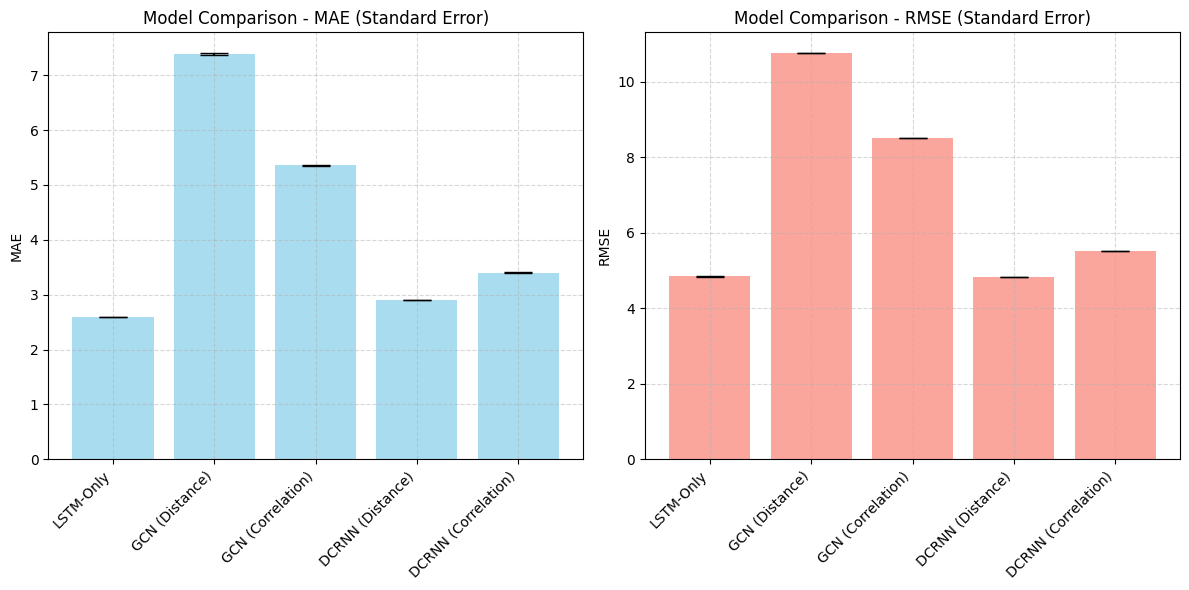

Standard Errors for MAE: LSTM-Only: 0.0043, GCN (Distance): 0.0226, GCN (Correlation): 0.0097, DCRNN (Distance): 0.0031, DCRNN (Correlation): 0.0040
Standard Errors for RMSE: LSTM-Only: 0.0012, GCN (Distance): 0.0048, GCN (Correlation): 0.0026, DCRNN (Distance): 0.0040, DCRNN (Correlation): 0.0042


In [33]:
# Cell 24: Bar graph comparison of all 5 models
from math import sqrt
# Model Names
model_names = [
    "LSTM-Only", 
    "GCN (Distance)", 
    "GCN (Correlation)",
    "DCRNN (Distance)", 
    "DCRNN (Correlation)", 
]

# MAE means and stds
mae_means = [
    lstm_mae_mean, 
    gcn_dist_mae_mean, 
    gcn_corr_mae_mean,
    dcrnn_dist_mae_mean, 
    dcrnn_corr_mae_mean
]

mae_stds = [
    lstm_mae_std, 
    gcn_dist_mae_std, 
    gcn_corr_mae_std,
    dcrnn_dist_mae_std, 
    dcrnn_corr_mae_std
]

# RMSE means and stds
rmse_means = [
    lstm_rmse_mean, 
    gcn_dist_rmse_mean, 
    gcn_corr_rmse_mean,
    dcrnn_dist_rmse_mean, 
    dcrnn_corr_rmse_mean
]

rmse_stds = [
    lstm_rmse_std, 
    gcn_dist_rmse_std, 
    gcn_corr_rmse_std,
    dcrnn_dist_rmse_std, 
    dcrnn_corr_rmse_std, 
]

# Compute Std errors
mae_err = [s/sqrt(3) for s in mae_stds]
rmse_err = [s/sqrt(3) for s in rmse_stds]

x = np.arange(len(model_names))

width = 0.4
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for MAE
ax[0].bar(x, mae_means, yerr=mae_err, align='center', alpha=0.7, ecolor='black', capsize=10, color='skyblue')
ax[0].set_ylabel('MAE')
ax[0].set_xticks(x)
ax[0].set_xticklabels(model_names, rotation=45, ha='right')
ax[0].set_title('Model Comparison - MAE (Standard Error)')
ax[0].grid(True, linestyle='--', alpha=0.5)

# Bar chart for RMSE
ax[1].bar(x, rmse_means, yerr=rmse_err, align='center', alpha=0.7, ecolor='black', capsize=10, color='salmon')
ax[1].set_ylabel('RMSE')
ax[1].set_xticks(x)
ax[1].set_xticklabels(model_names, rotation=45, ha='right')
ax[1].set_title('Model Comparison - RMSE (Standard Error)')
ax[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("Standard Errors for MAE:", 
      f"LSTM-Only: {mae_err[0]:.4f}, GCN (Distance): {mae_err[1]:.4f}, GCN (Correlation): {mae_err[2]:.4f},",
        f"DCRNN (Distance): {mae_err[3]:.4f}, DCRNN (Correlation): {mae_err[4]:.4f}")

print("Standard Errors for RMSE:",
        f"LSTM-Only: {rmse_err[0]:.4f}, GCN (Distance): {rmse_err[1]:.4f}, GCN (Correlation): {rmse_err[2]:.4f},",
            f"DCRNN (Distance): {rmse_err[3]:.4f}, DCRNN (Correlation): {rmse_err[4]:.4f}")
